In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import os
from PIL import Image

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = 0 if "RealArt" in self.root_dir else 1
        return image, label

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load datasets
real_dataset = CustomDataset('/kaggle/input/ai-generated-images-vs-real-images/RealArt/RealArt/', transform=transform)
generated_dataset = CustomDataset('/kaggle/input/ai-generated-images-vs-real-images/AiArtData/AiArtData/', transform=transform)

# Split datasets into train, validation, and test
real_train, real_val_test = train_test_split(real_dataset, test_size=0.2, random_state=42)
gen_train, gen_val_test = train_test_split(generated_dataset, test_size=0.2, random_state=42)

real_val, real_test = train_test_split(real_val_test, test_size=0.5, random_state=42)
gen_val, gen_test = train_test_split(gen_val_test, test_size=0.5, random_state=42)

# Combine datasets for training, validation, and test
train_dataset = torch.utils.data.ConcatDataset([real_train, gen_train])
val_dataset = torch.utils.data.ConcatDataset([real_val, gen_val])
test_dataset = torch.utils.data.ConcatDataset([real_test, gen_test])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize ResNet34 model
model = models.resnet34(pretrained=True)

# Modify the fully connected layers for binary classification with ReLU activation
num_ftrs = model.fc.in_features

# Define the sequential module for the new classification layers
classifier_layers = nn.Sequential(
    nn.Linear(num_ftrs, 128),  # Fully connected layer with 128 output features
    nn.ReLU(),  # ReLU activation
    nn.Linear(128, 1)  # Fully connected layer to output a single value for binary classification
)

# Replace the original fully connected layer (model.fc) with the new classifier
model.fc = classifier_layers

# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0002)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import time
import torch
import torch.optim as optim

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')  # Initialize with a very large number
best_model_path = "best_model.pth"  # Path to save the best model

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the model if validation loss has improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  Saved best model with val loss: {best_val_loss:.4f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training complete. Elapsed time: {elapsed_time:.2f} seconds")

Epoch 1/10, Train Loss: 0.6005, Val Loss: 0.4861
  Saved best model with val loss: 0.4861
Epoch 2/10, Train Loss: 0.4828, Val Loss: 0.4617
  Saved best model with val loss: 0.4617
Epoch 3/10, Train Loss: 0.4227, Val Loss: 0.4635
Epoch 4/10, Train Loss: 0.4262, Val Loss: 0.4726
Epoch 5/10, Train Loss: 0.3850, Val Loss: 0.4545
  Saved best model with val loss: 0.4545
Epoch 6/10, Train Loss: 0.3694, Val Loss: 0.4956
Epoch 7/10, Train Loss: 0.3946, Val Loss: 0.4697
Epoch 8/10, Train Loss: 0.3219, Val Loss: 0.5087
Epoch 9/10, Train Loss: 0.3156, Val Loss: 0.5861
Epoch 10/10, Train Loss: 0.3577, Val Loss: 0.4236
  Saved best model with val loss: 0.4236
Training complete. Elapsed time: 14.79 seconds


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        predicted_labels.extend(predicted.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

predicted_labels = np.array(predicted_labels).astype(int)
true_labels = np.array(true_labels).astype(int)

# Compute and print classification report
report = classification_report(true_labels, predicted_labels, target_names=["Real", "Generated"], digits=4)
print(report)

              precision    recall  f1-score   support

        Real     0.8065    0.5682    0.6667        44
   Generated     0.7164    0.8889    0.7934        54

    accuracy                         0.7449        98
   macro avg     0.7614    0.7285    0.7300        98
weighted avg     0.7568    0.7449    0.7365        98



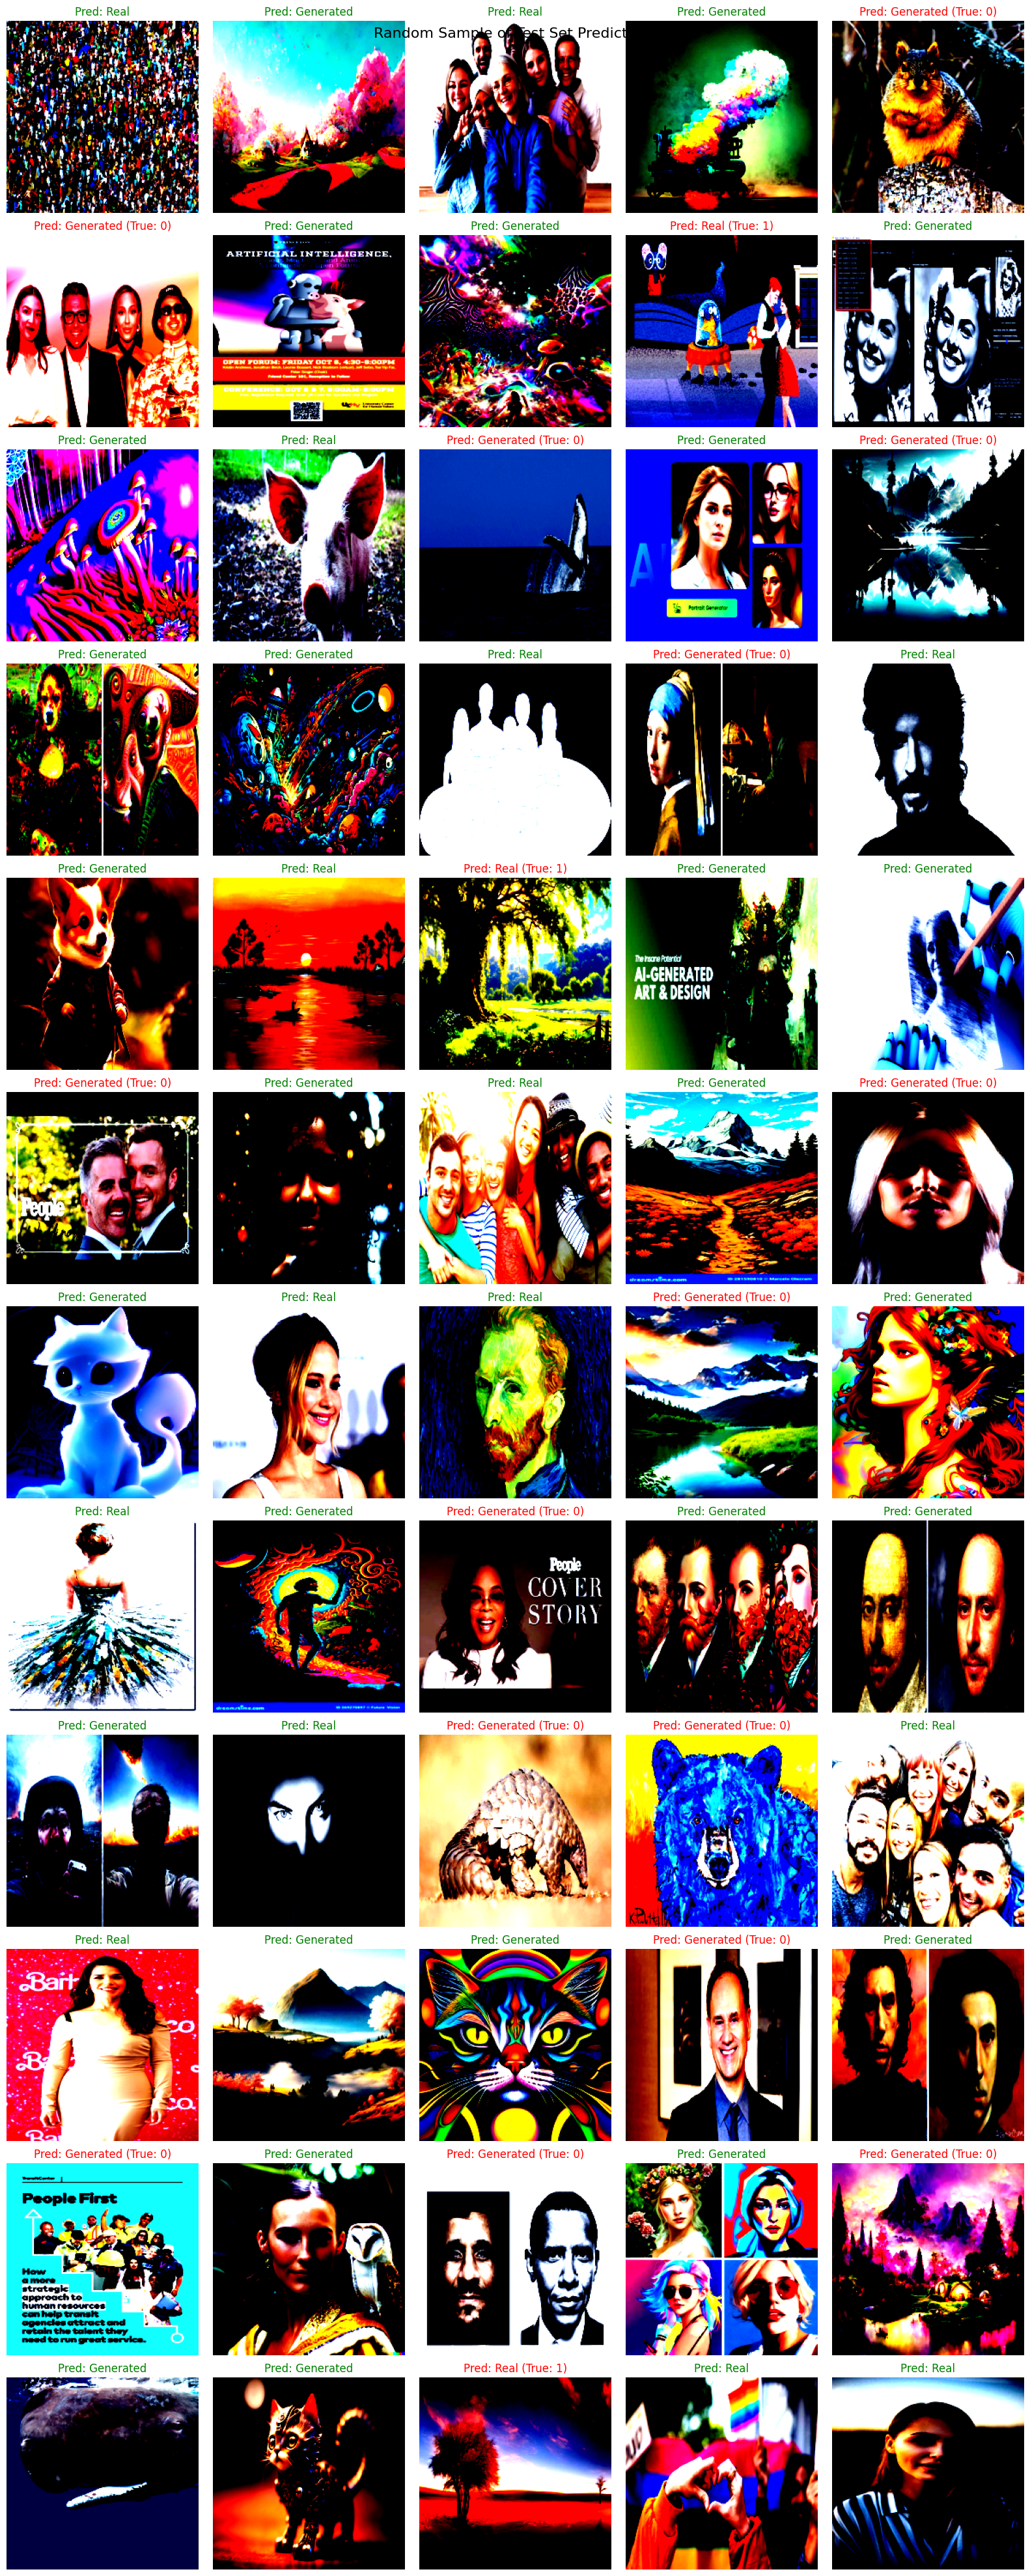

              precision    recall  f1-score   support

        Real     0.8065    0.5682    0.6667        44
   Generated     0.7164    0.8889    0.7934        54

    accuracy                         0.7449        98
   macro avg     0.7614    0.7285    0.7300        98
weighted avg     0.7568    0.7449    0.7365        98



In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming `test_loader` is already defined from your code

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth labels
predicted_labels = []
true_labels = []
images_to_show = []
num_images_to_show = 60

# Collect predictions and true labels from the test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        predicted_labels.extend(predicted.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())
        images_to_show.extend(images.cpu().numpy())

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels).astype(int)
true_labels = np.array(true_labels).astype(int)
images_to_show = np.array(images_to_show)

# Select 20 random indices from the test set
random_indices = np.random.choice(len(images_to_show), num_images_to_show, replace=False)

# Plot the selected images along with their predictions and ground truth labels
fig, axes = plt.subplots(12, 5, figsize=(16, 40))
fig.suptitle('Random Sample of Test Set Predictions', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    idx = random_indices[i]
    image = images_to_show[idx]
    true_label = true_labels[idx]
    predicted_label = predicted_labels[idx]
    
    # Display the image
    image = np.moveaxis(image, 0, -1)  # Move channel axis (3rd dim) to the last for displaying
    ax.imshow(image)
    ax.axis('off')
    
    # Set title based on prediction
    if predicted_label == 0:
        pred_label = "Real"
    else:
        pred_label = "Generated"
    
    if true_label == predicted_label:
        ax.set_title(f'Pred: {pred_label}', color='green')
    else:
        ax.set_title(f'Pred: {pred_label} (True: {true_label})', color='red')

plt.tight_layout()
plt.show()

# Compute and print classification report
report = classification_report(true_labels, predicted_labels, target_names=["Real", "Generated"], digits=4)
print(report)